Finished splitting images into train/val/test at: Project3_split
Found 19454 images belonging to 2 classes.
Found 5931 images belonging to 2 classes.
Found 5910 images belonging to 2 classes.
Train samples: 19454
Val samples:   5931
Test samples:  5910
Class indices: {'damage': 0, 'no_damage': 1}


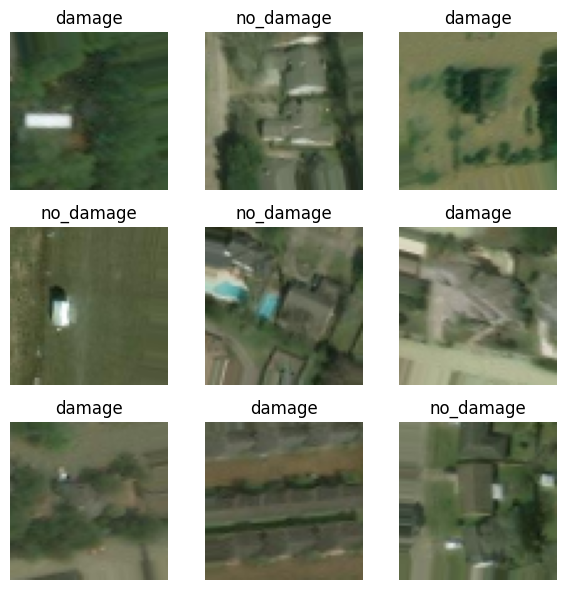


========== [MODEL 1] Training Dense ANN ==========
Epoch 1/10
608/608 [==============================] - 25s 41ms/step - loss: 0.6849 - accuracy: 0.6494 - val_loss: 0.6372 - val_accuracy: 0.6662
Epoch 2/10
608/608 [==============================] - 25s 41ms/step - loss: 0.6382 - accuracy: 0.6649 - val_loss: 0.6369 - val_accuracy: 0.6662
Epoch 3/10
608/608 [==============================] - 24s 40ms/step - loss: 0.6383 - accuracy: 0.6648 - val_loss: 0.6369 - val_accuracy: 0.6662
Epoch 4/10
608/608 [==============================] - 24s 40ms/step - loss: 0.6380 - accuracy: 0.6649 - val_loss: 0.6369 - val_accuracy: 0.6662
Epoch 5/10
608/608 [==============================] - 24s 39ms/step - loss: 0.6380 - accuracy: 0.6649 - val_loss: 0.6369 - val_accuracy: 0.6662
Epoch 6/10
608/608 [==============================] - 24s 40ms/step - loss: 0.6383 - accuracy: 0.6649 - val_loss: 0.6369 - val_accuracy: 0.6662
Epoch 7/10
608/608 [==============================] - 24s 40ms/step - loss: 0.6379 -

In [4]:
# Filename: train_part1_and_part2_fixed.py

import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, AveragePooling2D, Flatten, Dense, Dropout, Activation
)

###############################################################################
# PART 1: DATA PREPROCESSING & VISUALIZATION
###############################################################################

# 1A. Define the source folder (contains "damage/" and "no_damage/")
#    This folder was cloned from the GitHub repo:
#    coe379L-sp25/datasets/unit03/Project3/damage
#    coe379L-sp25/datasets/unit03/Project3/no_damage
SOURCE_DIR = "coe379L-sp25/datasets/unit03/Project3"

# 1B. Define a new folder for our split
SPLIT_DIR = "Project3_split"

# Desired split ratios for train/val/test
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

# 1C. Create subfolders for train/val/test
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(SPLIT_DIR, split, "damage"), exist_ok=True)
    os.makedirs(os.path.join(SPLIT_DIR, split, "no_damage"), exist_ok=True)

def split_images(source_folder, class_name):
    """
    Splits images in 'source_folder' (damage or no_damage)
    into train/val/test subfolders in SPLIT_DIR.
    """
    all_files = [
        f for f in os.listdir(source_folder)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    random.shuffle(all_files)

    total = len(all_files)
    train_end = int(TRAIN_RATIO * total)
    val_end   = int((TRAIN_RATIO + VAL_RATIO) * total)

    train_files = all_files[:train_end]
    val_files   = all_files[train_end:val_end]
    test_files  = all_files[val_end:]

    # Copy into train/val/test
    for f in train_files:
        shutil.copy(
            os.path.join(source_folder, f),
            os.path.join(SPLIT_DIR, "train", class_name, f)
        )
    for f in val_files:
        shutil.copy(
            os.path.join(source_folder, f),
            os.path.join(SPLIT_DIR, "val", class_name, f)
        )
    for f in test_files:
        shutil.copy(
            os.path.join(source_folder, f),
            os.path.join(SPLIT_DIR, "test", class_name, f)
        )

# Split both classes
damage_source    = os.path.join(SOURCE_DIR, "damage")
no_damage_source = os.path.join(SOURCE_DIR, "no_damage")

split_images(damage_source,    "damage")
split_images(no_damage_source, "no_damage")

print("Finished splitting images into train/val/test at:", SPLIT_DIR)

# 1D. Create ImageDataGenerators
#    We add some data augmentation to help the model learn both classes.
IMG_HEIGHT = 64
IMG_WIDTH  = 64
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(SPLIT_DIR, "train")
val_dir   = os.path.join(SPLIT_DIR, "val")
test_dir  = os.path.join(SPLIT_DIR, "test")

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Train samples:", train_generator.samples)
print("Val samples:  ", val_generator.samples)
print("Test samples: ", test_generator.samples)
print("Class indices:", train_generator.class_indices)

# 1E. Optional: visualize a small batch
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    # Check mapping to ensure correctness:
    # if train_generator.class_indices == {'damage': 0, 'no_damage': 1},
    # then a label of 0 => "damage", 1 => "no_damage"
    label_str = "damage" if y_batch[i] == 0 else "no_damage"
    plt.title(label_str)
    plt.axis("off")
plt.tight_layout()
plt.show()


###############################################################################
# PART 2: MODEL DESIGN, TRAINING & EVALUATION
###############################################################################

# Helper for evaluation
def evaluate_and_report(model, data_gen, data_name="Test"):
    """
    Evaluates the model on data_gen, prints classification report & confusion matrix,
    and returns accuracy.
    We use zero_division=0 to suppress the warning if no samples are predicted for a class.
    """
    loss, acc = model.evaluate(data_gen, verbose=0)
    print(f"[{data_name}] Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    preds = model.predict(data_gen, verbose=0)
    y_pred = (preds > 0.5).astype(int).flatten()
    y_true = data_gen.classes

    # If train_generator.class_indices == {'damage': 0, 'no_damage': 1},
    # then y_pred==0 => damage, y_pred==1 => no_damage
    target_names = ["damage", "no_damage"]

    print(f"{data_name} Classification Report (zero_division=0):")
    print(classification_report(
        y_true,
        y_pred,
        target_names=target_names,
        zero_division=0
    ))
    print(f"{data_name} Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    return acc

# 2A. Define the three architectures

def build_dense_ann(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    """
    A simple dense (fully connected) ANN:
    Flatten -> Dense -> Dropout -> Dense -> Dropout -> Dense
    """
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lenet5(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    """
    Adapted LeNet-5 for RGB images and binary classification.
    """
    model = Sequential()
    # Block 1
    model.add(Conv2D(6, (5,5), padding='same', input_shape=input_shape))
    model.add(Activation('tanh'))
    model.add(AveragePooling2D())
    # Block 2
    model.add(Conv2D(16, (5,5), padding='valid'))
    model.add(Activation('tanh'))
    model.add(AveragePooling2D())
    # Flatten -> FC
    model.add(Flatten())
    model.add(Dense(120, activation='tanh'))
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_alternate_lenet5(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    """
    Alternate LeNet-5 style:
    - 2 Conv + AvgPool blocks
    - Flatten -> Dense -> Output
    """
    model = Sequential()
    model.add(Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape))
    model.add(AveragePooling2D((2,2)))
    model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
    model.add(AveragePooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 2B. Train each model & evaluate on test set
# Increase EPOCHS for a better chance to learn both classes
EPOCHS = 10

print("\n========== [MODEL 1] Training Dense ANN ==========")
dense_model = build_dense_ann()
dense_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)
dense_acc = evaluate_and_report(dense_model, test_generator, "Test (Dense ANN)")

print("\n========== [MODEL 2] Training LeNet-5 ==========")
lenet_model = build_lenet5()
lenet_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)
lenet_acc = evaluate_and_report(lenet_model, test_generator, "Test (LeNet-5)")

print("\n========== [MODEL 3] Training Alternate-LeNet-5 ==========")
alt_lenet_model = build_alternate_lenet5()
alt_lenet_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)
alt_lenet_acc = evaluate_and_report(alt_lenet_model, test_generator, "Test (Alt-LeNet-5)")

# 2C. Pick the best-performing model
results = {
    "Dense ANN": dense_acc,
    "LeNet-5": lenet_acc,
    "Alternate-LeNet-5": alt_lenet_acc
}
best_model_name = max(results, key=results.get)
best_accuracy = results[best_model_name]
print(f"\nBest model: {best_model_name} with test accuracy = {best_accuracy:.4f}")

# 2D. Save the best model in the recommended *.keras format
if best_model_name == "Dense ANN":
    best_model = dense_model
elif best_model_name == "LeNet-5":
    best_model = lenet_model
else:
    best_model = alt_lenet_model

best_model.save("saved_model.keras")  # recommended format
print("\nSaved the best model to 'saved_model.keras' (no HDF5 warning).")
